<a href="https://colab.research.google.com/github/PedroTapia98/Manglares/blob/main/Manglar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.9 MB/s eta 0:00:00


In [2]:
pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 5.3 MB/s eta 0:00:00


In [3]:
pip install geopandas

In [4]:
import rasterio
from rasterio.mask import mask
import fiona
from spectral import imshow
import numpy as np
from spectral import imshow, save_rgb
import functools
import matplotlib.pyplot as plt
from osgeo import gdal

b4 = gdal.Open('/content/drive/MyDrive/Manglar/LC09_L2SP_024047_20220405_20220407_02_T1_SR_B4.TIF')
b5 = gdal.Open('/content/drive/MyDrive/Manglar/LC09_L2SP_024047_20220405_20220407_02_T1_SR_B5.TIF')

B5 = b5.ReadAsArray()
B4 = b4.ReadAsArray()

Cortar o hacer una mascara de la imagen satelital y el área seleccionada definida por un archivo shapefile

In [5]:
# Ruta de la imagen satelital en formato TIFF
image_path = '/content/drive/MyDrive/Manglar/LC09_L2SP_024047_20220405_20220407_02_T1_SR_B4.TIF'

# Ruta del archivo shapefile
shapefile_path = '/content/drive/MyDrive/DELIMI.shp'

# Leer la imagen satelital
image = rasterio.open(image_path)

# Leer el shapefile
with fiona.open(shapefile_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Leer la imagen satelital y cortarla utilizando las geometrías del shapefile
clipped_image, transform = mask(image, shapes, crop=True)

# Guardar el resultado en un nuevo archivo TIFF
clipped_image_path = '/content/drive/MyDrive/imagen_recortadaB4.tif'
with rasterio.open(clipped_image_path, 'w', **image.meta) as dest:
    dest.write(clipped_image)

# Cerrar la imagen satelital
image.close()

In [6]:
# Ruta de la imagen satelital en formato TIFF
image_path2 = '/content/drive/MyDrive/Manglar/LC09_L2SP_024047_20220405_20220407_02_T1_SR_B5.TIF'
# Leer la imagen satelital
image2 = rasterio.open(image_path2)
# Leer la imagen satelital y cortarla utilizando las geometrías del shapefile
clipped_image, transform = mask(image2, shapes, crop=True)
# Guardar el resultado en un nuevo archivo TIFF
clipped_image_path2 = '/content/drive/MyDrive/imagen_recortadaB5.tif'
with rasterio.open(clipped_image_path2, 'w', **image2.meta) as dest:
    dest.write(clipped_image)

# Cerrar la imagen satelital
image2.close()

Abrir imagenes exportadas anteriormente

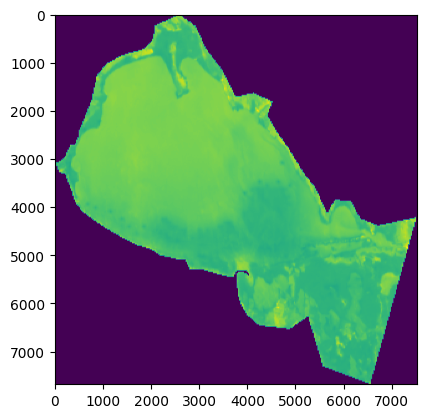

In [7]:
ds = gdal.Open('/content/drive/MyDrive/imagen_recortadaB4.tif')
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
arrayb4 = band.ReadAsArray()

plt.figure()
plt.imshow(arrayb4)

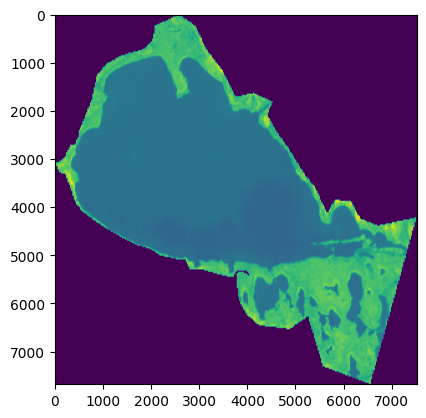

In [8]:
ds1 = gdal.Open('/content/drive/MyDrive/imagen_recortadaB5.tif')
proj = ds1.GetProjection()

band = ds1.GetRasterBand(1)
arrayb5 = band.ReadAsArray()

plt.figure()
plt.imshow(arrayb5)

Realizar NDVI


<ipython-input-9-0e0b34fe6c1e>:1: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (arrayb5 - arrayb4)/(arrayb5 + arrayb5)


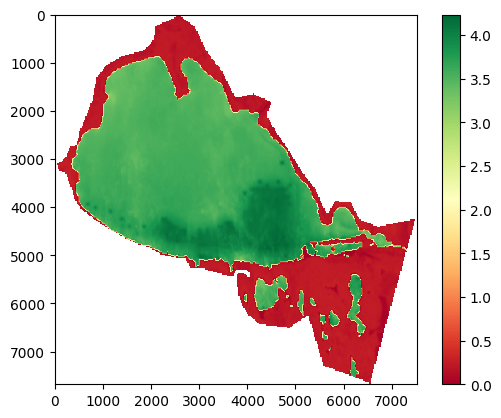

In [9]:
ndvi = (arrayb5 - arrayb4)/(arrayb5 + arrayb5)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()

Tomar solo los valores donde define el área del manglar

In [10]:
# Definir el rango de valores a mostrar
vmin = 0.2
vmax = 0.33
# Crear una máscara para los valores en el rango especificado
mask = np.logical_and(ndvi >= vmin, ndvi <= vmax)
# Aplicar la máscara al NDVI para obtener solo los valores en el rango
masked_ndvi = np.where(mask, ndvi, np.nan)

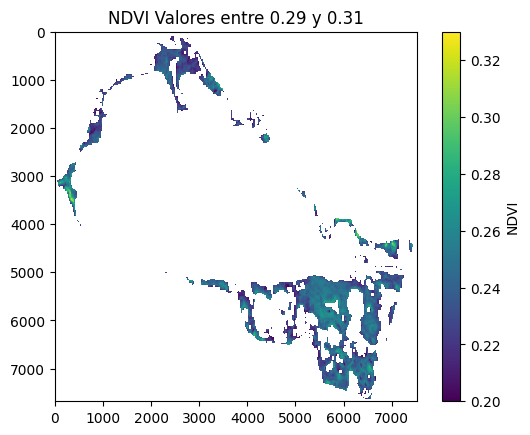

In [11]:
# Mostrar la imagen resultante
plt.imshow(masked_ndvi, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(label='NDVI')
plt.title('NDVI Valores entre 0.29 y 0.31')
plt.show()

Convertir a una imágen binaria

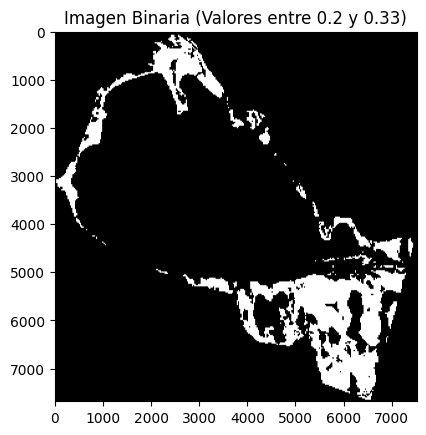

In [12]:
#Crear imagen binaria
binary_image = np.where(mask, 1, 0)
# Mostrar la imagen binaria
plt.imshow(binary_image, cmap='gray')
plt.title('Imagen Binaria (Valores entre 0.2 y 0.33)')
plt.show()

Calcular de acuerdo a los pixeles de valor 1 la equivalencia en metros y kilometros para ver cuantos metros y kilometos de managlar hay en su totalidad

In [13]:
# Obtener el número de píxeles de valor 1
num_pixeles = np.count_nonzero(binary_image == 1)

# Obtener la resolución espacial de la imagen (tamaño de cada píxel en metros)
resolucion_x = resolucion_y = 30  # Ejemplo: 30 metros

# Calcular el área total en metros cuadrados
area_total = num_pixeles * resolucion_x * resolucion_y

# Convertir el área de metros cuadrados a kilómetros cuadrados
area_total_km2 = area_total / 1000000

print("Número de píxeles de valor 1:", num_pixeles)
print("Área total de manglar en metros cuadrados:", area_total)
print("Área total de manglar en kilómetros cuadrados:", area_total_km2)

Número de píxeles de valor 1: 6004681
Área total de manglar en metros cuadrados: 5404212900
Área total de manglar en kilómetros cuadrados: 5404.2129
